Parts of the code in this colab are modified or re-used from RhinoChess's implementation of DeepChess : https://colab.research.google.com/drive/1V8KEI0qYJiqSAjN2vUTdpTHvw1pkrZB0#scrollTo=SaBsinerz-cz

In [ ]:
import chess
import chess.svg
import chess.pgn 
import numpy as np 
import random
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython.display import SVG, display
import time
import sklearn
import copy
from pathlib import Path
from tqdm import tqdm
import time 

torch.manual_seed(123)

In the following code blocks, the position datasets are loaded into dataloaders. I only loaded the necessary information for the encoder/decoder model in the dataloader objects. Also, I shuffled the observations so that the winning and losing positions aren't all bunched together in the dataset.

In [ ]:
# Datasets from local files (for debugging)
## from google.colab import drive
## drive.mount('/content/drive')

Direct download of the datasets and trained model weights

In [ ]:
!gdown --id 1GCR9xVlIKXa0v-Q6XCbWPNDGkA6JRyAL
!gdown --id 1diprHGEiViYrm7KFbRCxClq90T3iKp3I  
!gdown --id 19MnhZkDMqOz3Tw1oOmvvm3DeuLqGqMmQ
!gdown --id 1JUAr_ljsmgOq8edVCQm43KxERQpSGd75

Downloading...
From: https://drive.google.com/uc?id=1GCR9xVlIKXa0v-Q6XCbWPNDGkA6JRyAL
To: /content/data_500K.h5
781MB [00:03, 222MB/s]
Downloading...
From: https://drive.google.com/uc?id=1diprHGEiViYrm7KFbRCxClq90T3iKp3I
To: /content/DeepChess_weights.pth
4.81MB [00:00, 29.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=19MnhZkDMqOz3Tw1oOmvvm3DeuLqGqMmQ
To: /content/Pos2Vec_weights.pth
6.45MB [00:00, 102MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JUAr_ljsmgOq8edVCQm43KxERQpSGd75
To: /content/8moves_v3.pgn
8.04MB [00:00, 71.0MB/s]


In [ ]:
# get data directory

data_dir = "/content/data_500K.h5" 

# Load Data and Compute Train/Test Splits
hf = h5py.File(data_dir,'r')
X_win_train,X_win_val,Y_win_train,Y_win_val = train_test_split(np.array(hf.get('X_win')), 
                                                   np.array(hf.get('Y_win')), 
                                                   test_size=0.2, random_state=2)
X_lose_train,X_lose_val,Y_lose_train,Y_lose_val = train_test_split(np.array(hf.get('X_lose')), 
                                                   np.array(hf.get('Y_lose')), 
                                                   test_size=0.2, random_state=2)

hf.close()

In [ ]:
# Train
X_win_train = torch.tensor(X_win_train).float()
X_lose_train = torch.tensor(X_lose_train).float()

Y_win_train = torch.tensor(Y_win_train).float()
Y_lose_train = torch.tensor(Y_lose_train).float()

catX_train = torch.cat((X_win_train, X_lose_train))
catY_train = torch.cat((Y_win_train, Y_lose_train))

train_data = TensorDataset(catX_train, catY_train)
winData_train = TensorDataset(X_win_train,Y_win_train)
loseData_train = TensorDataset(X_lose_train,Y_lose_train)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)

# Validation
X_win_val = torch.tensor(X_win_val).float()
X_lose_val = torch.tensor(X_lose_val).float()

Y_win_val = torch.tensor(Y_win_val).float()
Y_lose_val = torch.tensor(Y_lose_val).float()

catX_val = torch.cat((X_win_train, X_lose_val))
catY_val = torch.cat((Y_win_train, Y_lose_val))

val_data = TensorDataset(catX_val, catY_val)
winData_val = TensorDataset(X_win_val,Y_win_val)
loseData_val = TensorDataset(X_lose_val,Y_lose_val)

val_loader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=False)


Below I just verified that the observations are of correct size.

In [ ]:
for i in train_data:
  print(i[0].size())
  break

torch.Size([773])


In the following code block, I defined the model and the training and evaluation functions. 

In [ ]:
class Pos2Vec(nn.Module):
  def __init__(self):
    super(Pos2Vec, self).__init__()
    # Encoding
    self.fc1 = nn.Linear(773, 600)
    self.fc2 = nn.Linear(600, 400)
    self.fc3 = nn.Linear(400, 200)
    self.fc4 = nn.Linear(200, 100)
    # Decoding
    self.fc5 = nn.Linear(100, 200)
    self.fc6 = nn.Linear(200, 400)
    self.fc7 = nn.Linear(400, 600)
    self.fc8 = nn.Linear(600, 773)
      
  def forward(self, pos):
    # Encoding
    x = F.relu(self.fc1(pos))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))

    # Decoding
    x = F.relu(self.fc5(x))
    x = F.relu(self.fc6(x))
    x = F.relu(self.fc7(x))
    x = F.relu(self.fc8(x))
    return x

def train(model, data, optimizer, criterion):
    total_loss = 0.0
    model.train()
    for X in tqdm(data):
      X = X[0].to(device)
      out = model(X)
      loss = criterion(out, X)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      total_loss += loss.item()
    return total_loss 
  

def evaluate(model, data, criterion):  
  total_loss = 0.0
  model.eval()
  with torch.no_grad():
      for X in tqdm(data):
          X = X[0].to(device)
          out = model(X)
          loss = criterion(out, X)
          total_loss += loss.item()
  return total_loss 

Then I trained the auto-encoder. 

In [ ]:
EPOCHS = 50

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# train 
model = Pos2Vec().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.MSELoss()

best_valid_loss = 10000.0
best_state_dict = copy.deepcopy(model.state_dict())
for epoch in range(EPOCHS):
    train_loss = train(model, train_loader, optimizer, criterion)
    valid_loss = evaluate(model, val_loader, criterion)

    print('Epoch {} | Train loss {:.3f} | Valid loss {:.3f} '.format(epoch, train_loss, valid_loss))

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_state_dict = copy.deepcopy(model.state_dict())
        torch.save(best_state_dict, "/content/Pos2Vec_weights.pth")

Load Pos2Vec model from saved weights

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Pos2Vec().to(device)
model.load_state_dict(torch.load("/content/Pos2Vec_weights.pth"))

<All keys matched successfully>

Here I'm just comparing the model predictions and the corresponding  bit board representations to make sure the model works properly. 

In [ ]:
import random
i = random.randint(0,len(val_data))
X = model(val_data[i][0].cuda())

# print(X) # Original bit board
# print(val_data[i][0]) # Predicted board from model

The function declared below returns the trained Pos2Vec model vector output

In [ ]:
def get_encoding(model, input):
  get_feature_vec = torch.nn.Sequential(*list(model.children())[:4])
  encoding = get_feature_vec(input)
  return encoding

# Testing function 
enc1 = get_encoding(model, val_data[0][0].cuda())
print(enc1.size())

torch.Size([100])


The DeepChess model is initiated.

In [ ]:
class DeepChess(nn.Module):
    def __init__(self):
        super(DeepChess, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(200,500),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(500,1048),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(1048,500),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(500,100),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(100,2)
        )

    def forward(self,x1,x2):
        x = torch.cat((x1,x2))
        x = self.layers(x)
        return F.softmax(x, dim=0)

DeepChess_model = DeepChess()
DeepChess_model = DeepChess_model.to(device)

The DeepChess model is trained on random pairs of losses and wins on the train data.

In [ ]:
# DeepChess = DeepChess()
lr = 3e-5
criterion = nn.MSELoss()
optimizer = optim.Adam(DeepChess_model.parameters(),lr=lr)

epochs = 75
accuracy = []
best_train_loss = 100000

win_data_range = range(len(winData_train))
loss_data_range = range(len(loseData_train))

val_win_data_range = range(len(winData_val))
val_loss_data_range = range(len(loseData_val))

batch = 4096

for epoch in range(epochs):  
    train_loss = 0.0
    val_loss = 0.0
    DeepChess_model.train()

    idx_win = random.sample(win_data_range,batch)
    idx_loss = random.sample(loss_data_range,batch)
    
    for i in range(batch):
        win_input_train, label = winData_train[idx_win[i]]
        loss_input_train, label = loseData_train[idx_loss[i]]

        win_input_enc = get_encoding(model, win_input_train.cuda())
        win_input_enc = win_input_enc.to(device)

        loss_input_enc = get_encoding(model, loss_input_train.cuda())
        loss_input_enc = loss_input_enc.to(device)

        optimizer.zero_grad()

        # Shuffle labels
        if random.randint(1,2) == 1:
            # Reverse wins and losses
            output = DeepChess_model(loss_input_enc, win_input_enc).unsqueeze(0)
            label = torch.tensor([[0,1]]).float()
            label = label.to(device)
            loss = criterion(output, label)

        else:    
            output = DeepChess_model(win_input_enc, loss_input_enc).unsqueeze(0)
            label = torch.tensor([[1,0]]).float()
            label = label.to(device)
            loss = criterion(output, label)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()   

    if train_loss < best_train_loss:
        best_valid_loss = train_loss
        best_state_dict = copy.deepcopy(DeepChess_model.state_dict())
        torch.save(best_state_dict, "/content/DeepChess_weights.pth")

    print('Epoch {} | Train loss {:.5f} '.format(epoch, train_loss / batch))

The models are reloaded

In [ ]:
# Re-loading models from saved weights
pos2vec = Pos2Vec().to(device)
pos2vec.load_state_dict(torch.load("/content/Pos2Vec_weights.pth"))

DeepChess_model = DeepChess().to(device)
DeepChess_model.load_state_dict(torch.load("/content/DeepChess_weights.pth"))

<All keys matched successfully>

The accuracy of the model is calculated on the validation set

In [ ]:
# source : RhinoChess colab
def test_on_validation(model,winData=winData_val,loseData=loseData_val):
    model.eval()
    correct = 0
    with torch.no_grad():
        for (data1,data2) in zip(winData,loseData):   
            input_w,_ = data1
            input_l,_ = data2

            input_w = get_encoding(pos2vec, input_w.cuda())
            input_l = get_encoding(pos2vec, input_l.cuda())

            input_w = input_w.to(device)
            input_l = input_l.to(device)

            if random.randint(1,2) == 1:
                # Reverse wins and losses
                output = model(input_l,input_w)
                if torch.argmax(output) == torch.tensor(1):
                    correct += 1
            else:    
                output = model(input_w,input_l)
                if torch.argmax(output) == torch.tensor(0):
                    correct += 1
            
        acc = 100 * correct / len(winData_val)
        print('Accuracy on Validation Set:', acc,'%')
        return acc

test_on_validation(DeepChess_model)

Accuracy on Validation Set: 85.067 %


85.067

The output of the model is compared to the labels to confirm that the model predictions are sensible. 

In [ ]:
import random
i = random.randint(0,len(winData_val))
ii = random.randint(0,len(winData_val))

win_input_val, label_win = winData_val[i]
loss_input_val, label_loss = loseData_val[ii]

valwin_input_enc = get_encoding(pos2vec, win_input_val.cuda())
valwin_input_enc = valwin_input_enc.to(device)

valoss_input_enc = get_encoding(pos2vec, loss_input_val.cuda())
valoss_input_enc = valoss_input_enc.to(device)

# Shuffle inputs
if random.randint(1,2) == 1:
    # Reverse wins and losses
    output = DeepChess_model(valoss_input_enc, valwin_input_enc)
    labels = (label_loss, label_win)
else:    
    output = DeepChess_model(valwin_input_enc, valoss_input_enc)
    labels = (label_win, label_loss)

print(output)
print(labels)

tensor([0.3041, 0.6959], device='cuda:0', grad_fn=<SoftmaxBackward>)
(tensor(0.), tensor(1.))


In [ ]:
# source : RhinoChess colab
def to_bitboard(board):
   bb = np.zeros((2,6,64),dtype=np.uint8) # players x pieces x board-size    
   for colour in range(2):
      for piece in range(6):
         for square in range(64):
            cur_piece = board.piece_at(square)
            if cur_piece is not None:
               if cur_piece.piece_type == piece+1 and cur_piece.color == bool(colour):
                  bb[colour][piece][square] = 1
   
   info = np.zeros(5,dtype=np.uint8)
   info[0] = board.has_kingside_castling_rights(chess.WHITE)
   info[1] = board.has_kingside_castling_rights(chess.BLACK)
   info[2] = board.has_queenside_castling_rights(chess.WHITE)
   info[3] = board.has_queenside_castling_rights(chess.BLACK)   
   info[4] = board.turn

   bb = bb.flatten()
   bb = np.concatenate((bb,info))
   return bb

In [ ]:
def get_bitboard(board):
    '''
    params
    ------
    board : chess.pgn board object
        board to get state from
    returns
    -------
    bitboard representation of the state of the game
    64 * 6 + 5 dim binary numpy vector
    64 squares, 6 pieces, '1' indicates the piece is at a square
    5 extra dimensions for castling rights queenside/kingside and whose turn
    '''

    bitboard = np.zeros(64*6*2+5)

    piece_idx = {'p': 0, 'n': 1, 'b': 2, 'r': 3, 'q': 4, 'k': 5}

    for i in range(64):
        if board.piece_at(i):
            color = int(board.piece_at(i).color) + 1
            bitboard[(piece_idx[board.piece_at(i).symbol().lower()] + i * 6) * color] = 1

    bitboard[-1] = int(board.turn)
    bitboard[-2] = int(board.has_kingside_castling_rights(True))
    bitboard[-3] = int(board.has_kingside_castling_rights(False))
    bitboard[-4] = int(board.has_queenside_castling_rights(True))
    bitboard[-5] = int(board.has_queenside_castling_rights(False))

    return bitboard

In [ ]:
def alphabeta(node, depth, alpha, beta, maximizingPlayer):
	if depth == 0:
		return node
	if maximizingPlayer:
		v = -1
		for move in node.legal_moves:
			cur = copy.copy(node)
			cur.push(move)
			if v == -1:
				v = alphabeta(cur, depth-1, alpha, beta, False) 
			if alpha == -1:
				alpha = v
		
			v = netPredict(v, alphabeta(cur, depth-1, alpha, beta, False))[0]
			alpha = netPredict(alpha, v)[0] 
			if beta != 1:
				if netPredict(alpha, beta)[0] == alpha:
					break
		return v 
	else:
		v = 1
		for move in node.legal_moves:
			cur = copy.copy(node)
			cur.push(move)
			if v == 1:
				v = alphabeta(cur, depth-1, alpha, beta, True) 
			if beta == 1:
				beta = v
			
			v = netPredict(v, alphabeta(cur, depth-1, alpha, beta, True))[1]
			beta = netPredict(beta, v)[1] 
			if alpha != -1:
				if netPredict(alpha, beta)[0] == alpha:
					break
		return v 

In [ ]:
def netPredict(b1,b2):
    if type(b1) == int:
      return (-9,-9)
    else:
      x1 = torch.tensor(get_bitboard(b1)).float()
      x1 = get_encoding(pos2vec, x1.cuda())
      x1 = x1.to(device)
    
    if type(b2) == int:
      return (-9,-9)
    else:
      x2 = torch.tensor(get_bitboard(b2)).float()
      x2 = get_encoding(pos2vec, x2.cuda())
      x2 = x2.to(device) 

    output = DeepChess_model(x1,x2)
    if torch.argmax(output) == torch.tensor(0):
        return (b1,b2)
    else:
        return (b2,b1)
  

In [ ]:
def showBoard(b,flip=False):
    display(SVG(chess.svg.board(b,size=300,flipped=flip)))

In [ ]:
# source : RhinoChess colab
def findMoveInBook(b):
    opening_book = open("/content/8moves_v3.pgn") #Better opening book? 
    game = chess.pgn.read_game(opening_book)
    b_temp = game.board()
    while True:
        for move in game.main_line():
            if len(b_temp.move_stack) == len(b.move_stack):
                if b_temp == b:
                    return move
                break
            b_temp.push(move)
        game = chess.pgn.read_game(opening_book)
        if game is None: #EOF
            break
        b_temp = game.board()
    return None

In [ ]:
def computerMove(board,depth,isWhite):

    # Check Opening Book
    if len(board.move_stack) < 8:
        bookMove = findMoveInBook(board)
        if bookMove is not None:
            print('Book Move Found: ', bookMove)
            board.push(bookMove)
            full_game.add_main_variation(bookMove)
            return board  
    print('No Book Moves Found, Using Engine...')
    alpha = -1 
    beta = 1
    best = -1
    startTime = time.time() # time move search
    if isWhite:
        for move in board.legal_moves:
            new_board = board.copy()
            new_board.push(move)
            if best == -1:
                best = alphabeta(new_board,depth-1,alpha,beta,True) 
                if best == -9:
                  stockfish2.set_fen_position(board.fen())
                  SF_move = stockfish2.get_best_move()
                  endTime = time.time()
                  print("Model move :")
                  print("found a move in " + format(endTime - startTime,".1f") + " seconds")
                  print(SF_move)
                  board.push_uci(SF_move)
                  full_game.add_main_variation(SF_move)
                  return board
                stockfish2.set_fen_position(board.fen())
                # move = board.parse_san(stockfish.get_best_move())
                move = stockfish2.get_best_move()
                bestMove = move
                break
                if beta == 1:
                    beta = best
            else:
                new_best = netPredict(best,alphabeta(new_board,depth-1,alpha,beta,True))[1]
                if new_best != best:
                    bestMove = move
                    best = new_best
                beta = netPredict(beta,best)[1]

    else:
        for move in board.legal_moves:
            new_board = board.copy()
            new_board.push(move)
            if best == -1:
                best = alphabeta(new_board,depth-1,alpha,beta,False) 
                stockfish.set_fen_position(board.fen())
                # move = board.parse_san(stockfish.get_best_move())
                move = stockfish.get_best_move()
                bestMove = move
                break
                if alpha == -1:
                    alpha = best
            else:
                new_best = netPredict(best,alphabeta(new_board,depth-1,alpha,beta,False))[0]
                if new_best != best:
                    bestMove = move
                    best = new_best
                alpha = netPredict(alpha,best)[0] 
    #time.sleep(60)
    endTime = time.time()
    print("Model move :")
    print("found a move in " + format(endTime - startTime,".1f") + " seconds")
    
    print(bestMove)
    board.push_uci(bestMove)
    full_game.add_main_variation(bestMove)
    return board

def playerMove(board):
      while True:
          try:
              move = input('Enter a move:\n')
              board.push_san(move)
              break
          except ValueError:
              print('Illegal move, try again')
      return board      

In [ ]:
!pip install stockfish

In [ ]:
!wget https://stockfishchess.org/files/stockfish_13_linux_x64_bmi2.zip

--2021-04-25 16:10:05--  https://stockfishchess.org/files/stockfish_13_linux_x64_bmi2.zip
Resolving stockfishchess.org (stockfishchess.org)... 104.25.158.9, 172.67.80.249, 104.25.159.9, ...
Connecting to stockfishchess.org (stockfishchess.org)|104.25.158.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12509627 (12M) [application/zip]
Saving to: ‘stockfish_13_linux_x64_bmi2.zip’

stockfish_13_linux_ 100%[===================>]  11.93M  31.0MB/s    in 0.4s    

2021-04-25 16:10:05 (31.0 MB/s) - ‘stockfish_13_linux_x64_bmi2.zip’ saved [12509627/12509627]



In [ ]:
!unzip stockfish_13_linux_x64_bmi2.zip

In [ ]:
from IPython.display import clear_output
from google.colab import output

from stockfish import Stockfish

stockfish = Stockfish("/content/stockfish_13_linux_x64_bmi2/stockfish_13_linux_x64_bmi2")
stockfish2 = Stockfish("/content/stockfish_13_linux_x64_bmi2/stockfish_13_linux_x64_bmi2")
stockfish2.set_elo_rating(700)
def playGame(rhino_dict="/content/DeepChess_weights.pth"):
    global rhino 
    global full_game
    global board
  
    rhino = DeepChess()
    rhino.load_state_dict(torch.load(rhino_dict))
    full_game = chess.pgn.Game()

    board = chess.Board()

    model_mode = int(input("Type '1' to play against the model \nType '2' to set the model against Stockfish\n"))
    max_depth = int(input("Set alphabeta's maximum search depth\n"))

    if model_mode == 1:
        isPlayerTurn = bool(random.randint(0,1))
        computerColour = not isPlayerTurn
        while board.is_game_over() == False:
            showBoard(board,flip=computerColour)
            if isPlayerTurn:
                board = playerMove(board)
            else:
                board = computerMove(board,max_depth,computerColour) 

            isPlayerTurn = not isPlayerTurn  
        # clear_output()
        output.clear()
        showBoard(board,flip=computerColour) # show final position

   
    if model_mode == 2:
        SF_elo = int(input("Input desired StockFish elo score\n"))
        stockfish.set_elo_rating(SF_elo)
        isPlayerTurn = bool(random.randint(0,1))
        if isPlayerTurn == 1: 
          SFcolor = "White" 
        else :
          SFcolor = "Black"
        
        print("Stockfish is playing white ? : "+ str(isPlayerTurn))
        computerColour = not isPlayerTurn
        while board.is_game_over() == False:
            showBoard(board,flip=computerColour)
            if isPlayerTurn:

                stockfish.set_fen_position(board.fen())
                SF_move = stockfish.get_best_move()
                print("StockFish move:")
                print(SF_move)
                # print("type:")
                # print(type(SF_move))
                board.push_uci(SF_move)
            else:
                board = computerMove(board,max_depth,computerColour) 

            isPlayerTurn = not isPlayerTurn  
        # clear_output()
        output.clear()
        showBoard(board,flip=computerColour) # show final position

    # Print Results
    if board.is_checkmate():
        print("Checkmate")
    elif board.is_stalemate():
        print("Draw: Stalemate")
    elif board.is_insufficient_material():
        print("Draw: Insufficient Material")

    print('game ends')
    print("Stockfish was playing  : "+ str(SFcolor))
    print("StockFish was playing at elo:" + str(SF_elo))

Exception ignored in: <function Stockfish.__del__ at 0x7f4bdef75f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/stockfish/models.py", line 291, in __del__
    self._put("quit")
  File "/usr/local/lib/python3.7/dist-packages/stockfish/models.py", line 72, in _put
    self.stockfish.stdin.flush()
BrokenPipeError: [Errno 32] Broken pipe


In [ ]:
def playPuzzle(rhino_dict="/content/DeepChess_weights.pth"):
    global rhino 
    global full_game
  
    rhino = DeepChess()
    rhino.load_state_dict(torch.load(rhino_dict))
    full_game = chess.pgn.Game()

    max_depth = int(input("Set alphabeta's maximum search depth\n"))
    fen_game = str(input("Paste fen string\n"))
    playerColour = int(input("is deepchess playing with white ? 1/0\n"))

    board = chess.Board(fen=fen_game)
    print("\n original board")
    showBoard(board)

    if playerColour == 1:
      board = computerMove(board,max_depth,True)
    else:
      board = computerMove(board,max_depth,False)
    
    print("\n predicted move")
    showBoard(board)

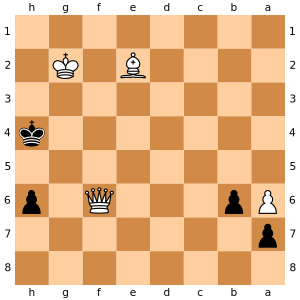

Checkmate
game ends
Stockfish was playing  : Black
StockFish was playing at elo:1200


In [ ]:
playGame()

Set alphabeta's maximum search depth
3
Paste fen string
7k/5rpP/8/p7/Np1p1p2/4nP1R/PP3r2/1KR5 w - - 0 1
is deepchess playing with white ? 1/0
1

 original board


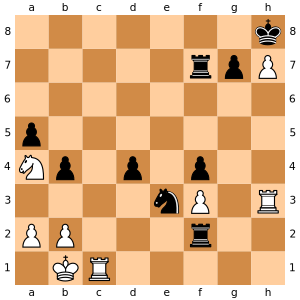

No Book Moves Found, Using Engine...
Model move :
found a move in 2.7 seconds
c1c8

 predicted move


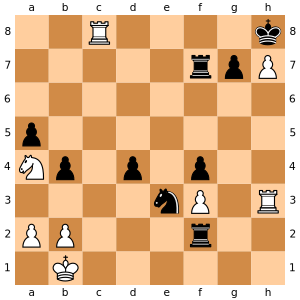

In [ ]:
playPuzzle()